This set of code examines the last ~90 years of data for the S&P 500 and provides a graphical answer to the question "on average, are there any days of the week on which it is better to buy or to sell a security that tracks the overall market?"

Please add the file sp500_index_90yrs.csv to your local directory in either Jupyter or Colab or add the path manually if running from a command interface.

The first cell installs and imports needed packages

In [ ]:
import numpy as np
import pandas as pd
import datetime

import math
from pathlib import Path
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.stats import multivariate_normal

!pip install prince
import prince

import matplotlib.pyplot as plt
from matplotlib import cm 
from matplotlib.colors import from_levels_and_colors
import seaborn as sns

%matplotlib inline


Please place the csv file of S&P 500 data in the local directory for either Colab or Jupyter and run the block below to load in the data.

In [28]:
sp500 = pd.read_csv('sp500_index_90yrs.csv')

The next code block gives a snapshot of the data itself.
There are 7 columns and 23,381 rows of data

In [5]:
print(sp500.shape)
print(sp500.head())

(23381, 7)
         Date       Open       High        Low      Close  Adj Close  Volume
0  1927-12-30  17.660000  17.660000  17.660000  17.660000  17.660000       0
1  1928-01-03  17.760000  17.760000  17.760000  17.760000  17.760000       0
2  1928-01-04  17.719999  17.719999  17.719999  17.719999  17.719999       0
3  1928-01-05  17.549999  17.549999  17.549999  17.549999  17.549999       0
4  1928-01-06  17.660000  17.660000  17.660000  17.660000  17.660000       0


The next block tests a function that returns the day of the week for any date.  It is tested on Jan 3, 1928, the second row of the dataset

In [ ]:
print(pd.Timestamp(sp500['Date'][1]).day_name())

Tuesday


The next block adds a column for the day of the week to the entire dataset.

In [6]:
def return_day(x):
  return pd.Timestamp(x).day_name()

sp500['Day'] = sp500.Date.apply(return_day)


And we print a snapshot to confirm that it worked.

In [7]:
print(sp500.head())

         Date       Open       High  ...  Adj Close  Volume        Day
0  1927-12-30  17.660000  17.660000  ...  17.660000       0     Friday
1  1928-01-03  17.760000  17.760000  ...  17.760000       0    Tuesday
2  1928-01-04  17.719999  17.719999  ...  17.719999       0  Wednesday
3  1928-01-05  17.549999  17.549999  ...  17.549999       0   Thursday
4  1928-01-06  17.660000  17.660000  ...  17.660000       0     Friday

[5 rows x 8 columns]


Next, we calculate the daily change in the index versus the previous closing price and again print a snapshot.

In [8]:
sp500['Change'] = sp500['Adj Close'].diff()

In [9]:
print(sp500.head())

         Date       Open       High  ...  Volume        Day    Change
0  1927-12-30  17.660000  17.660000  ...       0     Friday       NaN
1  1928-01-03  17.760000  17.760000  ...       0    Tuesday  0.100000
2  1928-01-04  17.719999  17.719999  ...       0  Wednesday -0.040001
3  1928-01-05  17.549999  17.549999  ...       0   Thursday -0.170000
4  1928-01-06  17.660000  17.660000  ...       0     Friday  0.110001

[5 rows x 9 columns]


Next, we drop the initial row, as it has no previous day listed to compare, before calculating the percent change for each day

In [10]:
sp500 = sp500.dropna()

In [11]:
sp500['Pc Change'] = sp500['Change'] / sp500['Adj Close'] * 100

A quick query of the mean and median value for the percent change reveals reasonable values: a mean daily (compounding) increase of 0.0156%

In [12]:
print(sp500['Pc Change'].mean())
#average daily percent change for the last ~100 yrs
print(sp500['Pc Change'].median())

0.015643007401214753
0.04836216580030041


We plot a histogram to examine the values visually.

In [13]:
binnedChange = pd.cut(sp500['Pc Change'], 10)
binnedChange.value_counts()

(-1.747, 2.25]        21704
(-5.745, -1.747]       1055
(2.25, 6.248]           510
(-9.743, -5.745]         57
(6.248, 10.246]          35
(-13.741, -9.743]        11
(10.246, 14.244]          6
(-17.738, -13.741]        1
(-25.774, -21.736]        1
(-21.736, -17.738]        0
Name: Pc Change, dtype: int64

Text(0.5, 0, 'Daily Change vs. Previous Close / %')

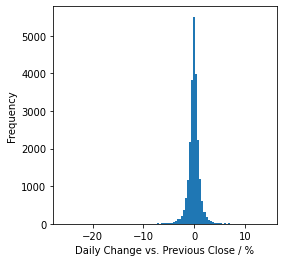

In [14]:
ax = (sp500['Pc Change']).plot.hist(figsize=(4, 4), bins=100)
ax.set_xlabel('Daily Change vs. Previous Close / %')

The next block of code creates datasets for each day of the week for data from the end of 1927 to the beginning of 2021, when these data were downloaded.

In [15]:
Mondays = sp500.where(sp500['Day'] == 'Monday')
Mondays.dropna(inplace=True)
Mondays.rename(columns={"Pc Change": "Monday Pc Change"}, inplace=True)
print(Mondays.head())

Tuesdays = sp500.where(sp500['Day'] == 'Tuesday')
Tuesdays.rename(columns={"Pc Change": "Tuesday Pc Change"}, inplace=True)
Tuesdays.dropna(inplace=True)

Wednesdays = sp500.where(sp500['Day'] == 'Wednesday')
Wednesdays.rename(columns={"Pc Change": "Wednesday Pc Change"}, inplace=True)
Wednesdays.dropna(inplace=True)

Thursdays = sp500.where(sp500['Day'] == 'Thursday')
Thursdays.rename(columns={"Pc Change": "Thursday Pc Change"}, inplace=True)
Thursdays.dropna(inplace=True)

Fridays = sp500.where(sp500['Day'] == 'Friday')
Fridays.rename(columns={"Pc Change": "Friday Pc Change"}, inplace=True)
Fridays.dropna(inplace=True)

print(Fridays.head())

          Date       Open       High  ...     Day    Change  Monday Pc Change
5   1928-01-09  17.500000  17.500000  ...  Monday -0.160000         -0.914286
10  1928-01-16  17.290001  17.290001  ...  Monday -0.289999         -1.677264
15  1928-01-23  17.639999  17.639999  ...  Monday  0.159999          0.907024
20  1928-01-30  17.490000  17.490000  ...  Monday -0.200001         -1.143516
25  1928-02-06  17.450001  17.450001  ...  Monday  0.050001          0.286539

[5 rows x 10 columns]
          Date       Open       High  ...     Day    Change  Friday Pc Change
4   1928-01-06  17.660000  17.660000  ...  Friday  0.110001          0.622882
9   1928-01-13  17.580000  17.580000  ...  Friday  0.110001          0.625717
14  1928-01-20  17.480000  17.480000  ...  Friday  0.100001          0.572088
19  1928-01-27  17.690001  17.690001  ...  Friday  0.060002          0.339186
24  1928-02-03  17.400000  17.400000  ...  Friday -0.229999         -1.321833

[5 rows x 10 columns]


In [16]:
sp500days = pd.concat([Mondays['Monday Pc Change'], Tuesdays['Tuesday Pc Change'], Wednesdays['Wednesday Pc Change'], \
                       Thursdays['Thursday Pc Change'], Fridays['Friday Pc Change']], axis=1)

Printing a snapshot and a histogram reveal the result.

In [17]:
sp500days.head()

,Monday Pc Change,Tuesday Pc Change,Wednesday Pc Change,Thursday Pc Change,Friday Pc Change
1,NaN,0.563063,NaN,NaN,NaN
2,NaN,NaN,-0.225739,NaN,NaN
3,NaN,NaN,NaN,-0.968661,NaN
4,NaN,NaN,NaN,NaN,0.622882
5,-0.914286,NaN,NaN,NaN,NaN


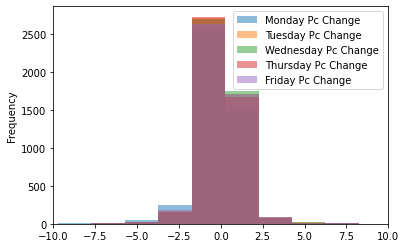

In [18]:
ax = sp500days.plot.hist(bins=20, alpha=0.5, xlim=(-10,10))

A box plot also reveals slightly different averages for each day but only small differences in the distributions.

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'Daily Change / %')

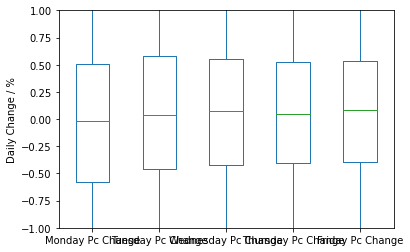

In [19]:
ax = sp500days.plot.box(ylim=(-1,1))
ax.set_ylabel('Daily Change / %')

Here we import more packages for statistical analysis and visualization.

In [22]:
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import power
import patsy
from decimal import Decimal
from scipy.stats import trim_mean

The code now calculates means, trim means (with top and bottom 10 percentiles worth of values excluded), and medians for the daily percent change for each day of the week.

In [23]:
Monday_mean = sp500days['Monday Pc Change'].mean()
Monday_trim_mean = trim_mean(sp500days['Monday Pc Change'].dropna(), 0.1)
# second argument for trim_mean of 0.1 drops the highest 10% and the lowest 10%
Monday_median = sp500days['Monday Pc Change'].median()
# print(Monday_mean)
# print(Monday_trim_mean)
# print(Monday_median)

Tuesday_mean = sp500days['Tuesday Pc Change'].mean()
Tuesday_trim_mean = trim_mean(sp500days['Tuesday Pc Change'].dropna(), 0.1)
Tuesday_median = sp500days['Tuesday Pc Change'].median()

Wednesday_mean = sp500days['Wednesday Pc Change'].mean()
Wednesday_trim_mean = trim_mean(sp500days['Wednesday Pc Change'].dropna(), 0.1)
Wednesday_median = sp500days['Wednesday Pc Change'].median()

Thursday_mean = sp500days['Thursday Pc Change'].mean()
Thursday_trim_mean = trim_mean(sp500days['Thursday Pc Change'].dropna(), 0.1)
Thursday_median = sp500days['Thursday Pc Change'].median()

Friday_mean = sp500days['Friday Pc Change'].mean()
Friday_trim_mean = trim_mean(sp500days['Friday Pc Change'].dropna(), 0.1)
Friday_median = sp500days['Friday Pc Change'].median()

In [24]:
print(Monday_mean, Tuesday_mean, Wednesday_mean, Thursday_mean, Friday_mean)

-0.09255415273955983 0.03392322455767107 0.06312599819818707 0.02868766707001281 0.03988272815992435


In [25]:
means = pd.DataFrame([[Monday_mean, Tuesday_mean, Wednesday_mean, Thursday_mean, Friday_mean]])
means.rename({0:'Mean'}, axis=0, inplace=True)
medians = pd.DataFrame([[Monday_median, Tuesday_median, Wednesday_median, Thursday_median, Friday_median]])
medians.rename({0:'Median'}, axis=0, inplace=True)

stats = pd.concat([means, medians])
stats.rename({0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday'}, axis=1, inplace=True)
stats.rename({0:'Mean', 1:'Median'}, axis=0, inplace=True)
stats


,Monday,Tuesday,Wednesday,Thursday,Friday
Mean,-0.092554,0.033923,0.063126,0.028688,0.039883
Median,-0.013248,0.036221,0.078507,0.050003,0.082737


Now we present the calculated means and medians visually.

Text(0, 0.5, 'Daily Change vs. Previous Close / %')

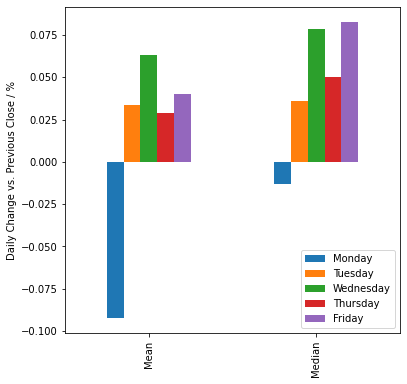

In [26]:
ax = stats.plot.bar(figsize=(6, 6), legend=True)
ax.set_ylabel('Daily Change vs. Previous Close / %')

In brief, the last 90 years of data for the S&P 500 say that if you are going to buy an index fund or a security that generally tracks the market, you should buy it on Monday near the close.  If you're going to sell, you should sell on Wednesday or Friday.

(Note that the differences in percent change are small with Mondays averaging down not quite 0.1% and Wednesdays averaging up about 0.62%.)

Though perhaps interesting, this is of course not intended as investment advice.  It is intended as a demonstration of the extraction of insights from large raw datasets.